🌱 Overall Methodology of the Code

1️⃣ Dataset Preparation 📂: Loads images from a directory, applies transformations (resize, crop, flip, normalize), and splits them into training and testing sets.

2️⃣ Efficient Triple Attention (ETA) Module 🔍: Enhances feature extraction by capturing spatial and channel-wise relationships in the image.

3️⃣ AttentionMix Data Augmentation 🎭: Blends images intelligently using attention-based masks to improve model generalization.

4️⃣ Model Architecture (ResNet50 + ETA) 🏗️: Uses a ResNet-50 backbone, integrates the ETA module for better feature extraction, and classifies crop diseases.

5️⃣ Training & Evaluation 📊: Trains the model with SGD and a learning rate scheduler, tests it on a separate dataset, and visualizes performance using accuracy and confusion matrices.

**Dataset Link:**
https://drive.google.com/drive/folders/1aHgbGOI14AVpk_fe67an2lU6ugtPvUmu?usp=sharing

In [ ]:
pip install torch torchvision numpy matplotlib opencv-python

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 55.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 24.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 18.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 6.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 11.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 61.2 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstalling nvidia-nvjitlink-cu12-12.5.82:
      Successfully uninstalled nvidia-nvjitlin

In [ ]:
import os
import random
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
import torchvision.models as models
import torchvision.datasets as datasets
import torch.nn.functional as F
from torch.utils.data import DataLoader, random_split
import cv2

# ==============================
# 1. DATASET PREPARATION
# ==============================
def create_dataloaders(data_dir, batch_size=16, train_ratio=0.8):
    """
    Loads images from a directory where each subfolder represents a class.
    Splits into train/test sets dynamically.
    """
    transform = transforms.Compose([
        transforms.Resize((512, 512)),
        transforms.RandomCrop((448, 448)),
        transforms.RandomHorizontalFlip(),
        transforms.RandomRotation(15),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])

    dataset = datasets.ImageFolder(root=data_dir, transform=transform)

    train_size = int(train_ratio * len(dataset))
    test_size = len(dataset) - train_size

    train_set, test_set = random_split(dataset, [train_size, test_size])

    train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True, num_workers=4)
    test_loader = DataLoader(test_set, batch_size=batch_size, shuffle=False, num_workers=4)

    return train_loader, test_loader, dataset.classes

# ==============================
# 2. EFFICIENT TRIPLE ATTENTION (ETA) MODULE
# ==============================
class EfficientTripleAttention(nn.Module):
    """
    ETA Module: Enhances feature representation by capturing cross-dimensional relationships.
    Fix: Adjusts Conv1D inputs for proper processing.
    """
    def __init__(self, channels):
        super(EfficientTripleAttention, self).__init__()

        # 1D convolutions for channel-wise attention
        self.conv1 = nn.Conv1d(channels, channels, kernel_size=1, groups=channels)
        self.conv2 = nn.Conv1d(channels, channels, kernel_size=1, groups=channels)
        self.conv3 = nn.Conv1d(channels, channels, kernel_size=1, groups=channels)

        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        # Ensure input is at least 3D for Conv1D
        if x.dim() == 4:  # (B, C, H, W) -> (B, C, 1, 1)
            x = x.squeeze(-1).squeeze(-1)  # (B, C)

        x = x.unsqueeze(-1)  # (B, C, 1) for Conv1D

        x_hc = self.conv1(x)
        x_wc = self.conv2(x)
        x_hw = self.conv3(x)

        attention = self.sigmoid(x_hc + x_wc + x_hw)
        return x * attention  # (B, C, 1)

# ==============================
# 3. ATTENTIONMIX DATA AUGMENTATION
# ==============================
class AttentionMix:
    """
    Data Augmentation: Mixes images based on attention maps instead of random cuts.
    """
    def __init__(self, alpha=0.2):
        self.alpha = alpha

    def __call__(self, img_batch):
        batch_size = img_batch.size(0)
        mixed_images = torch.zeros_like(img_batch)

        for i in range(batch_size):
            img1 = img_batch[i]  # Single image (C, H, W)
            img2 = img_batch[random.randint(0, batch_size - 1)]  # Another random image

            lam = np.random.beta(self.alpha, self.alpha)

            # Convert to NumPy for OpenCV operations
            img1_np = img1.permute(1, 2, 0).cpu().numpy() * 255
            img2_np = img2.permute(1, 2, 0).cpu().numpy() * 255

            # Convert to grayscale and threshold to get important regions
            gray = cv2.cvtColor(img1_np.astype(np.uint8), cv2.COLOR_RGB2GRAY)
            _, mask = cv2.threshold(gray, 128, 255, cv2.THRESH_BINARY)
            mask = mask / 255.0  # Normalize mask

            # Blend images based on the attention mask
            img_mixed = img1_np * mask[:, :, None] + img2_np * (1 - mask[:, :, None])
            img_mixed = torch.tensor(img_mixed / 255).permute(2, 0, 1).float().to(img_batch.device)

            # Store in batch
            mixed_images[i] = lam * img1 + (1 - lam) * img_mixed

        return mixed_images



# ==============================
# 4. MODEL ARCHITECTURE (ResNet50 + ETA)
# ==============================
class CropDiseaseModel(nn.Module):
    def __init__(self, num_classes):
        super(CropDiseaseModel, self).__init__()
        self.backbone = models.resnet50(pretrained=True)
        self.backbone.fc = nn.Identity()  # Remove last classification layer
        self.eta = EfficientTripleAttention(channels=2048)  # Apply ETA module
        self.fc = nn.Linear(2048, num_classes)  # Custom classifier

    def forward(self, x):
        x = self.backbone(x)  # ResNet-50 output is (B, 2048)
        x = self.eta(x)  # Apply ETA (now correctly handling shape)
        x = x.view(x.size(0), -1)  # Flatten for classifier
        x = self.fc(x)  # Final classification
        return x

# ==============================
# 5. TRAINING FUNCTION (Using Exact Paper Settings)
# ==============================
import torch
import torch.nn as nn
import torch.optim as optim

def train(model, train_loader, epochs=20, lr=0.001):
    device = torch.device("cuda")  # Assurer l'utilisation du GPU
    model.to(device)  # Déplacer le modèle sur le GPU

    criterion = nn.CrossEntropyLoss()
    optimizer = optim.SGD(model.parameters(), lr=lr, momentum=0.9, weight_decay=1e-5)
    scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=2, gamma=0.9)  # Décroît le LR tous les 2 epochs

    for epoch in range(epochs):
        model.train()
        total_loss = 0

        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)  # Déplacer sur GPU

            # Appliquer AttentionMix et s'assurer que mixed_images est sur GPU
            mixed_images = AttentionMix()(images).to(device)  # 🔥 Correction ici

            optimizer.zero_grad()
            outputs = model(mixed_images)  # Forward pass
            loss = criterion(outputs, labels)  # Calcul de la perte
            loss.backward()  # Backpropagation
            optimizer.step()  # Mise à jour des poids
            total_loss += loss.item()

        scheduler.step()  # Appliquer la décroissance du learning rate

        print(f"Epoch [{epoch+1}/{epochs}], Loss: {total_loss / len(train_loader):.4f}")



In [ ]:
from google.colab import drive
drive.mount('/content/drive')
data_path = "/content/drive/My Drive/Wheat_dataset/" # Chemin correct
import os

if os.path.exists(data_path):
    print("Dataset found at:", data_path)
    print("Files:", os.listdir(data_path))
else:
    print("Error: Dataset path not found!")


Mounted at /content/drive
Dataset found at: /content/drive/My Drive/Wheat_dataset/
Files: ['Yellow', 'Pawdery_mildew', 'Fusarium', 'Healthy', 'Loose Smut', 'Septoria', 'Brown', 'Stem']


In [ ]:


if __name__ == "__main__":
    train_loader, test_loader, classes = create_dataloaders(data_path, batch_size=16)

    model = CropDiseaseModel(num_classes=len(classes))
    train(model, train_loader, epochs=10, lr=0.001)


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNe

Epoch [1/10], Loss: 1.2685
Epoch [2/10], Loss: 0.8154
Epoch [3/10], Loss: 0.6013
Epoch [4/10], Loss: 0.4831
Epoch [5/10], Loss: 0.4139
Epoch [6/10], Loss: 0.3496
Epoch [7/10], Loss: 0.3062
Epoch [8/10], Loss: 0.2902
Epoch [9/10], Loss: 0.2547
Epoch [10/10], Loss: 0.2619


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Test Accuracy: 97.22%


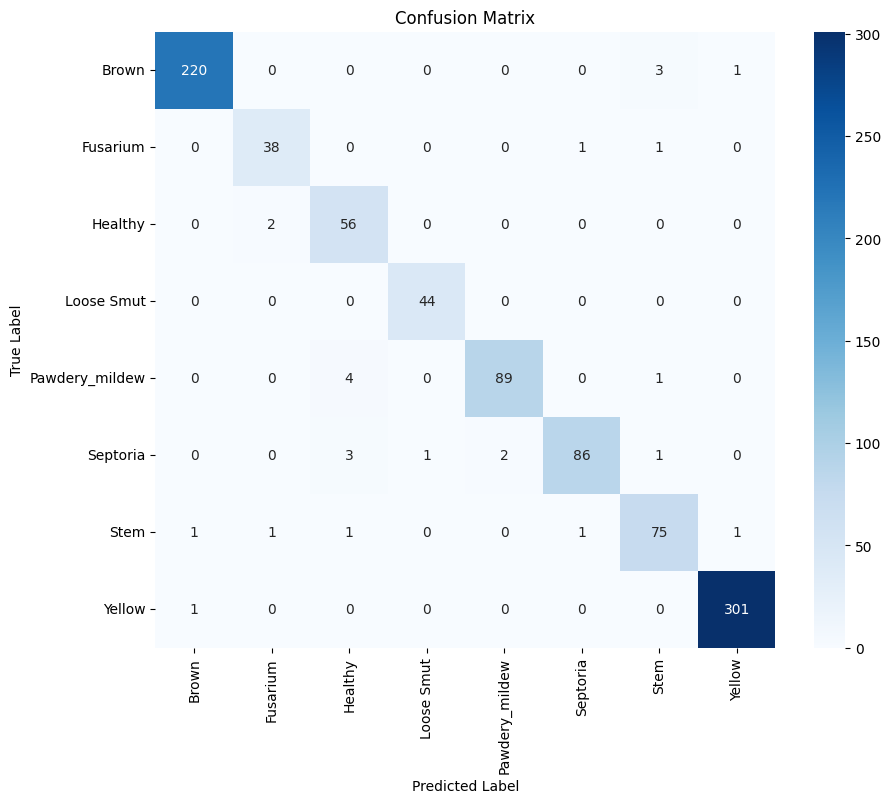

In [ ]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, accuracy_score

# ==============================
# TESTING FUNCTION
# ==============================
def test(model, test_loader):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)
    model.eval()  # Set model to evaluation mode

    all_preds = []
    all_labels = []

    with torch.no_grad():  # No gradient calculation during testing
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)

            outputs = model(images)  # Get predictions
            _, preds = torch.max(outputs, 1)  # Get class with highest probability

            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    # Compute accuracy
    accuracy = accuracy_score(all_labels, all_preds)
    print(f"Test Accuracy: {accuracy * 100:.2f}%")

    # Compute confusion matrix
    cm = confusion_matrix(all_labels, all_preds)
    return cm, accuracy

# ==============================
# PLOT CONFUSION MATRIX
# ==============================
def plot_confusion_matrix(cm, class_names):
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=class_names, yticklabels=class_names)
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.title("Confusion Matrix")
    plt.show()

# ==============================
# RUN TESTING
# ==============================
if __name__ == "__main__":
    cm, test_accuracy = test(model, test_loader)
    plot_confusion_matrix(cm, classes)

In [25]:
# ==============================
# GRAD-CAM IMPLEMENTATION
# ==============================
def generate_gradcam(model, image, target_class):
    model.eval()

    image.requires_grad_()

    output = model(image)
    loss = output[0, target_class]
    model.zero_grad()
    loss.backward()

    gradients = image.grad[0]
    pooled_gradients = torch.mean(gradients, dim=[1, 2], keepdim=True)
    activation_map = torch.sum(pooled_gradients * image[0], dim=0)

    # Normalize the activation map
    activation_map = F.relu(activation_map)
    activation_map = activation_map - activation_map.min()
    activation_map = activation_map / activation_map.max()

    return activation_map.cpu().detach().numpy()

def display_gradcam(image_path, activation_map):
    img = cv2.imread(image_path)
    img = cv2.resize(img, (448, 448))  # Resize to original input size
    heatmap = cv2.applyColorMap(np.uint8(255 * activation_map), cv2.COLORMAP_JET)
    superimposed_img = cv2.addWeighted(img, 0.5, heatmap, 0.5, 0)

    plt.imshow(superimposed_img)
    plt.axis("off")
    plt.show()


In [26]:
# ==============================
# LOAD & PREPROCESS IMAGE
# ==============================
def preprocess_image(image_path, image_size=(448, 448)):
    transform = transforms.Compose([
        transforms.Resize(image_size),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # Adjust if needed
    ])
    image = Image.open(image_path).convert("RGB")
    image = transform(image).unsqueeze(0)  # Add batch dimension
    return image.to(next(model.parameters()).device)  # Move to same device as model



In [27]:
# ==============================
# PREDICT & DISPLAY
# ==============================
def predict_and_gradcam(image_path, class_names):
    image = preprocess_image(image_path)

    # Make prediction
    model.eval()
    with torch.no_grad():
        output = model(image)
        _, predicted_class = torch.max(output, 1)
        predicted_label = class_names[predicted_class.item()]

    # Display prediction
    img = Image.open(image_path)
    plt.imshow(img)
    plt.title(f"Predicted: {predicted_label}")
    plt.axis("off")
    plt.show()

    # Generate Grad-CAM
    activation_map = generate_gradcam(model, image, predicted_class.item())
    display_gradcam(image_path, activation_map)

    return predicted_label



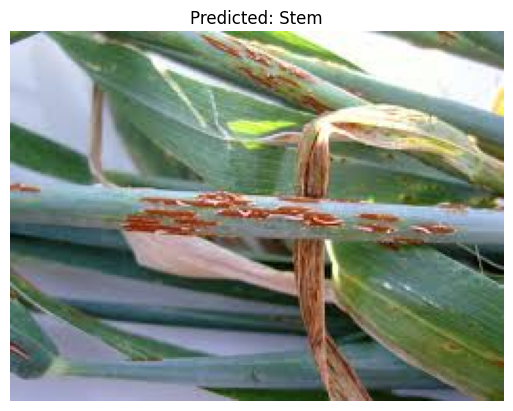

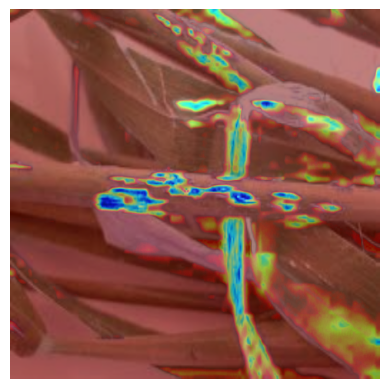

Model Prediction: Stem


In [28]:
# ==============================
# RUN THE TEST
# ==============================
if __name__ == "__main__":

    # Run Grad-CAM on a sample image
    image_path = "stem.jpg"  # Change to your test image path
    predicted_label = predict_and_gradcam(image_path, classes)
    print(f"Model Prediction: {predicted_label}")

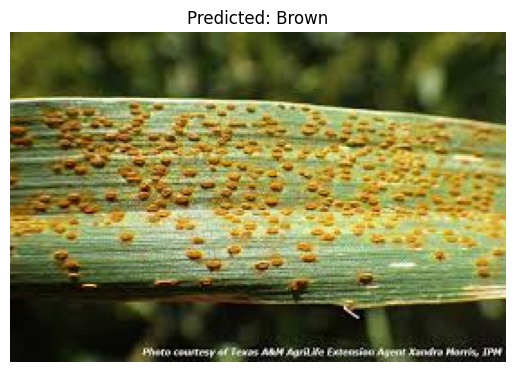

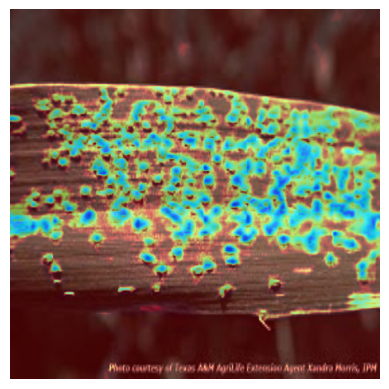

Model Prediction: Brown


In [30]:
# ==============================
# RUN THE TEST
# ==============================
if __name__ == "__main__":

    # Run Grad-CAM on a sample image
    image_path = "Brown.jpg"  # Change to your test image path
    predicted_label = predict_and_gradcam(image_path, classes)
    print(f"Model Prediction: {predicted_label}")

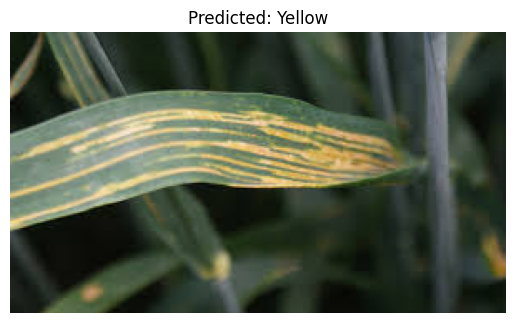

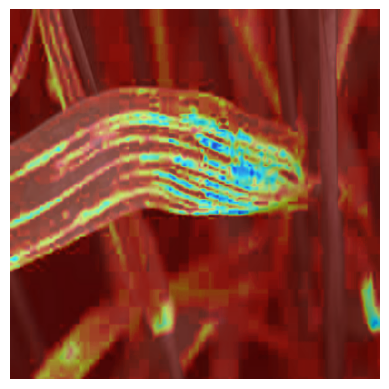

Model Prediction: Yellow


In [31]:
# ==============================
# RUN THE TEST
# ==============================
if __name__ == "__main__":

    # Run Grad-CAM on a sample image
    image_path = "yellow.jpg"  # Change to your test image path
    predicted_label = predict_and_gradcam(image_path, classes)
    print(f"Model Prediction: {predicted_label}")